In [6]:
#Je reviens à quelque chose de beaucoup plus simple. On va prouver que l'on obtient le bon FF pour STF classique. 
#Travaillons en mode dense, facile.
# This first version is for the classical STF. 
# Now, try to get to the domain-based STF...

import bempp.api 
import numpy as np
import mtf

from bempp.api.operators.boundary.sparse import identity
from bempp.api.assembly.blocked_operator import BlockedOperator, GeneralizedBlockedOperator

from mtf.utils import bhmie
from mtf.config import config
from mtf.functions import define_bempp_functions
from mtf.mtf.assembly.operators import GeneralizedBlockedOperator

from matplotlib import pyplot as plt
from decimal import Decimal

bempp.api.enable_console_logging()
M = 2

mtf.config.set_case("B")

tangential_trace, neumann_trace = define_bempp_functions(config)

k0, k1 = config["k_ext"], config["k_int"]
lambda_par, freq = config["lambda"], config["frequency"]

polarization = config["polarization"]
direction = config["direction"]

eps_rel = config["eps_rel"]
mu_rel = config["mu_rel"]
mu0 = config["mu_ext"]
mu1 = mu_rel * mu0

eta_rel = np.sqrt(mu_rel / eps_rel)

print("The exterior wavenumber is: {0}".format(k0))
print("The interior wavenumber is: {0}".format(k1))

print("----")
print("The exterior wavelenght is: {0}".format(lambda_par))
print("The exterior frequency is: {:.2E}".format(Decimal(freq)))

# To do: Go to the multi-domain STF...
segments = [[10], [10]]
swapped_normals = [[10], []]

k_int, k_ext = config["k_int"], config["k_ext"]

n = k_int / k_ext
refIndex = n
numAngles = 901
s1, s2, qext, qsca, qback, gsca = bhmie(k_ext, k_int / k_ext, numAngles)
angles = config['angles']

k_list = [k0]
eta_rel_list = [1]
mu_list = [mu0]

for index in range(M-1):
  k_list.append(k1)
  mu_list.append(mu1)
  eta_rel_list.append(eta_rel)


precision = 5

h = 2 * np.pi/(precision*k0)
grid = bempp.api.shapes.sphere(h=h)

print(h, ': h')
print(precision, ': precision')
print(grid.number_of_edges * 2, ': N')


dA = [bempp.api.function_space(grid, "RWG", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]

p1dA = [bempp.api.function_space(grid, "DP", 1, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]

rA = [bempp.api.function_space(grid, "RWG", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]
tA = [bempp.api.function_space(grid, "SNC", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]

multitrace_ops = []
# > Assemble all diagonal operators
for index in range(M):
  k = k_list[index]
  mu = mu_list[index]
  eta = eta_rel_list[index]
  efie = bempp.api.operators.boundary.maxwell.electric_field(dA[index], rA[index], tA[index], k)
  mfie = bempp.api.operators.boundary.maxwell.magnetic_field(dA[index], rA[index], tA[index], k)
  multitrace_ops.append(GeneralizedBlockedOperator([[mfie, eta * efie],[- 1/eta * efie, mfie]]))

# Define the final operator

block_system = [M * [None] for _ in range(M)]

for i in range(M):
  for j in range(M):
    if i == j:
      block_system[i][j] = 2 * multitrace_ops[i]
    else:
      all = segments[i] + segments[j]
      non_disjoint = np.unique(all).shape[0] != len(all)
      
      if non_disjoint:
        ident = identity(dA[j], rA[i], tA[i])
        op = BlockedOperator(2, 2)
        #op[0, 0] = -ident
        op[0, 0] = ident
        op[1, 1] = ident
        op.weak_form()
        #op[1, 1] = ident
        block_system[i][j] = op
      else:
        op = BlockedOperator(2, 2)
        zero = ZeroBoundaryOperator(dA[j], rA[i], tA[i])
        op[0, 0] = zero
        op[1, 1] = zero
        block_system[i][j] = op

lhs_op = GeneralizedBlockedOperator(block_system)
op_wf = lhs_op.weak_form()

rhs = [2 * bempp.api.GridFunction(rA[0], dual_space = tA[0], fun=tangential_trace),
      2 * bempp.api.GridFunction(rA[0], dual_space = tA[0], fun=neumann_trace)]

for i in range(1, M):
    zero_func = [bempp.api.GridFunction.from_zeros(dA[i]),bempp.api.GridFunction.from_zeros(dA[i])]
    rhs = rhs + zero_func


b = bempp.api.assembly.blocked_operator.projections_from_grid_functions_list(rhs, lhs_op.dual_to_range_spaces)
N = b.shape[0]
A = bempp.api.as_matrix(op_wf)
x = np.linalg.solve(A, b)

sol = bempp.api.assembly.blocked_operator.grid_function_list_from_coefficients(x.ravel(), lhs_op.domain_spaces)

far_field_points = config['far_field_points']
electric_far = bempp.api.operators.far_field.maxwell.electric_field(sol[1].space, far_field_points, k0)
magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(sol[0].space, far_field_points, k0)    

far_field =  electric_far * sol[1] + magnetic_far * sol[0]

A22 = far_field[2,:]
uh = 10 * np.log10(4 * np.pi * np.abs(A22[:1801]))
u =  10 * np.log10(4 * np.pi * np.abs(s1 / (-1j * k_ext) ))
rel_error = np.linalg.norm(uh - u) / np.linalg.norm(u)


print(rel_error)

bempp:HOST:INFO: Created grid with id d33d887e-25db-4ac2-8801-e2abb25894d0. Elements: 628. Edges: 942. Vertices: 316
bempp:HOST:WARNING: Setting include_boundary_dofs has no effect on this space type.
bempp:HOST:WARNING: Setting include_boundary_dofs has no effect on this space type.


The exterior wavenumber is: 5.0
The interior wavenumber is: 6.892024376045111
----
The exterior wavelenght is: 1.2566370614359172
The exterior frequency is: 2.39E+8

0.25132741228718347 : h
5 : precision
1884 : N


66 warnings generated.
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:417: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, [devices[i] for i in to_be_built_indices])
66 warnings generated.
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)
66 warnings generated.
66 warnings generated.


0.010816041057132016


/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)


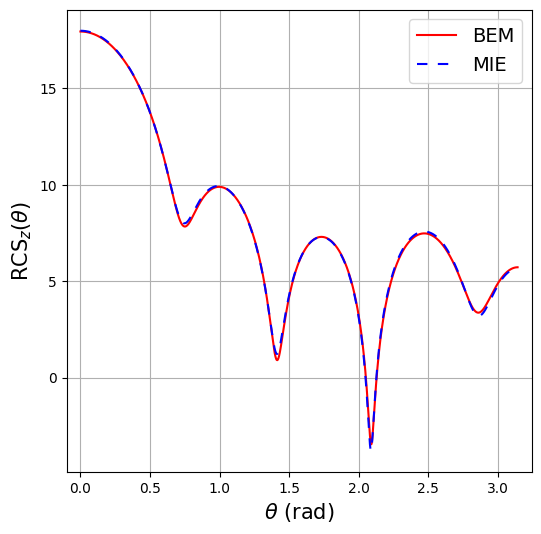

In [7]:
angles = config['angles']

fig, ax  = plt.subplots(1,1, figsize=(6,6))
plt.rcParams['figure.figsize'] = (15, 4) # Increase the figure size in the notebook

A22 = far_field[2,:]
uh = 10 * np.log10(4 * np.pi * np.abs(A22[:1801]))
u =  10 * np.log10(4 * np.pi * np.abs(s1 / (-1j * k_ext) ))
# -1j * kExt is to make agree with eqn 3.21 p70 tBohren and Huffman

ax.plot(angles[:1801], uh, '-r', label='BEM')
ax.plot(angles[:1801], u, 'b', label='MIE', linestyle=(0, (5, 5)))

ax.set_xlabel(r"$\theta$ (rad)", fontsize=15)
ax.set_ylabel(r"$\mathrm{RCS}_z(\theta)$", fontsize=15)

ymin, ymax = uh.min() - 1, uh.max() + 1
ax.legend(prop={'size': 14})
ax.grid()
plt.xlim(-0.1, np.pi + 0.1)
#plt.ylim(ymin, ymax)
#plt.savefig("plots/RCSSphere.pdf")
plt.show()